# Relative Strength Index


In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from utils import get_data, get_return_simulation
from strategies import rsi

plt.style.use("seaborn")


In [2]:
weights = [0.4, 0.5, 0.023, 0.033, 0.043]

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

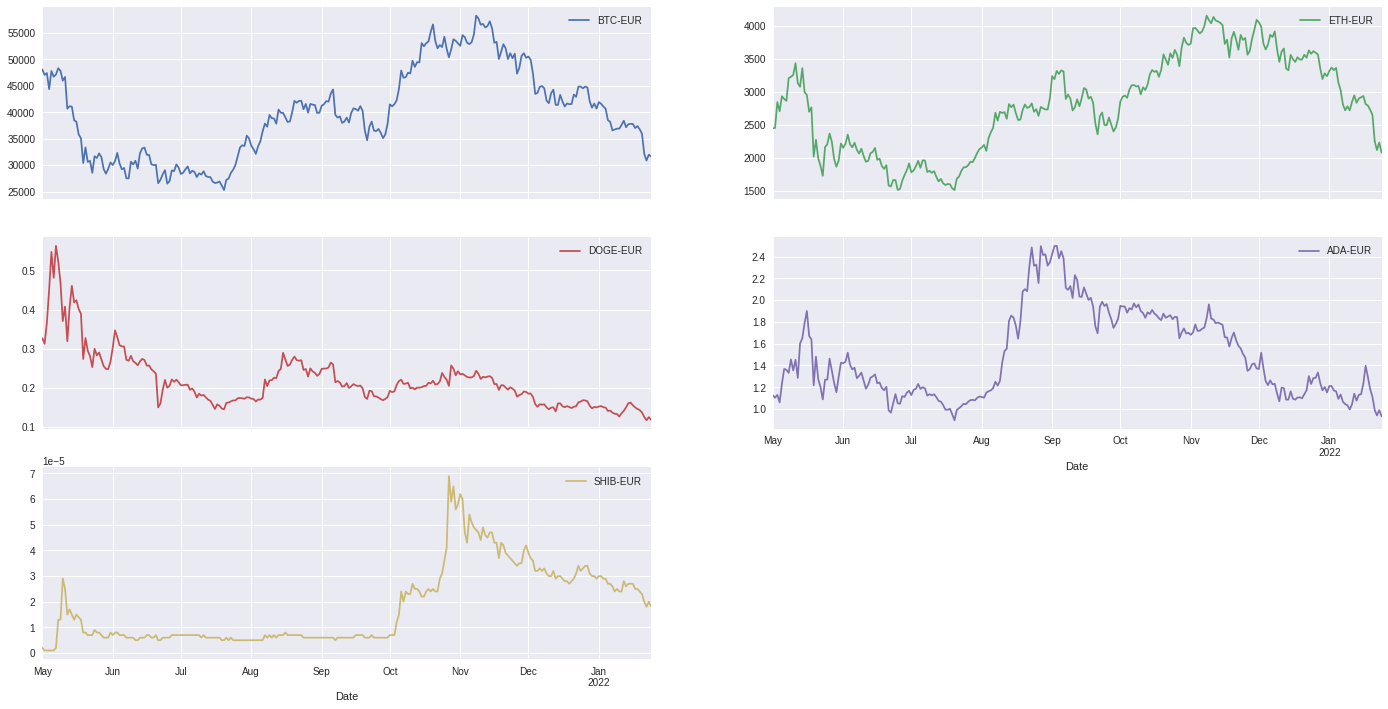

In [3]:
df, stocks = get_data('cryptos')
df = df.loc['2021-05-01':]

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))


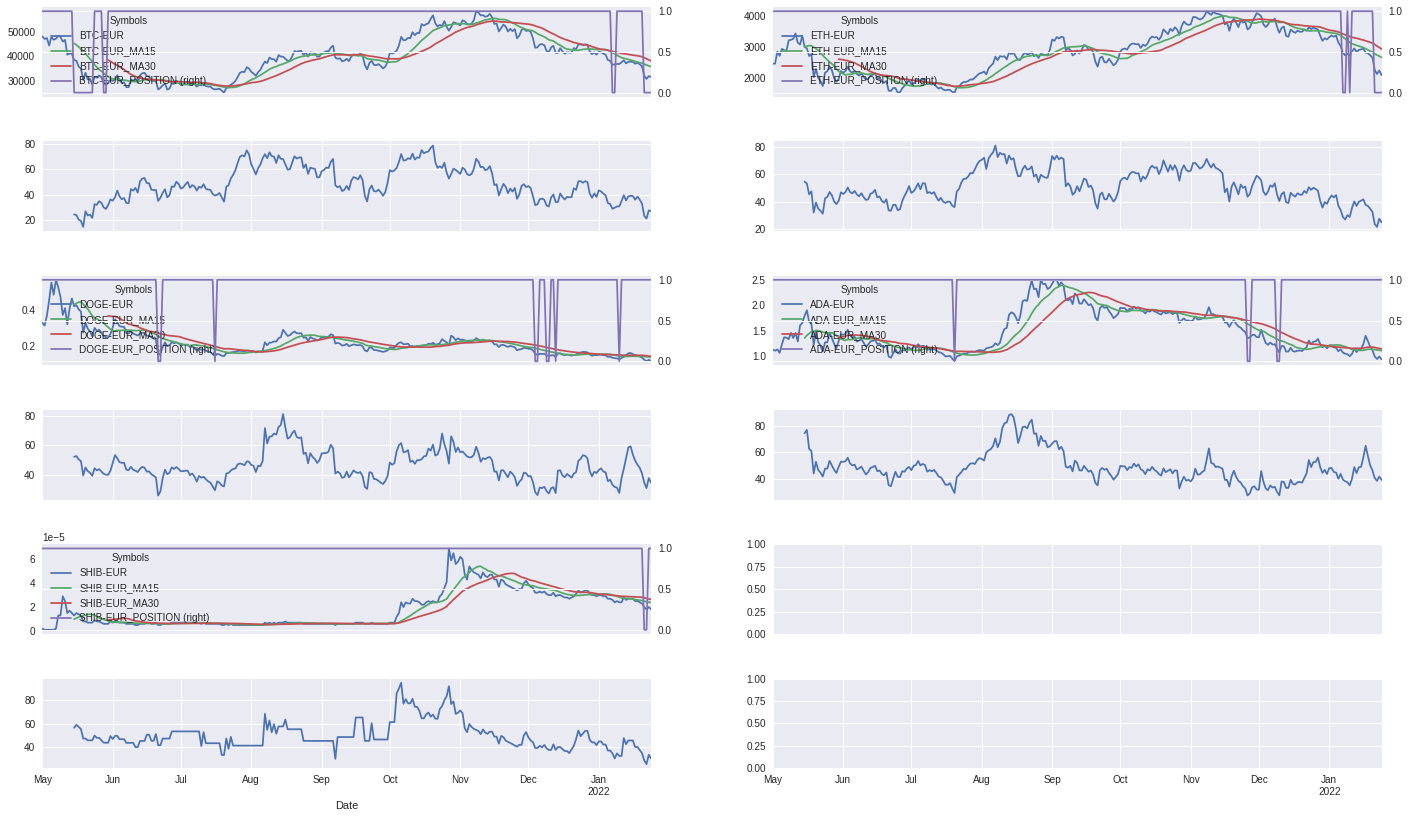

In [4]:
MA1 = 15
MA2 = 30

df = pd.concat(
    [
        df,
        df.rolling(MA1).mean().add_suffix(f"_MA{MA1}"),
        df.rolling(MA2).mean().add_suffix(f"_MA{MA2}"),
        rsi(df, stocks, periods=14),
    ],
    axis=1,
)

fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[[s, f"{s}_MA{MA1}", f"{s}_MA{MA2}", f"{s}_POSITION"]].plot(
        figsize=(24, 14), ax=axes[i // 2 * 2, i % 2], secondary_y=f"{s}_POSITION"
    )
    df[f"{s}_RSI"].plot(ax=axes[i // 2 * 2 + 1, i % 2])


## Generate buy signals


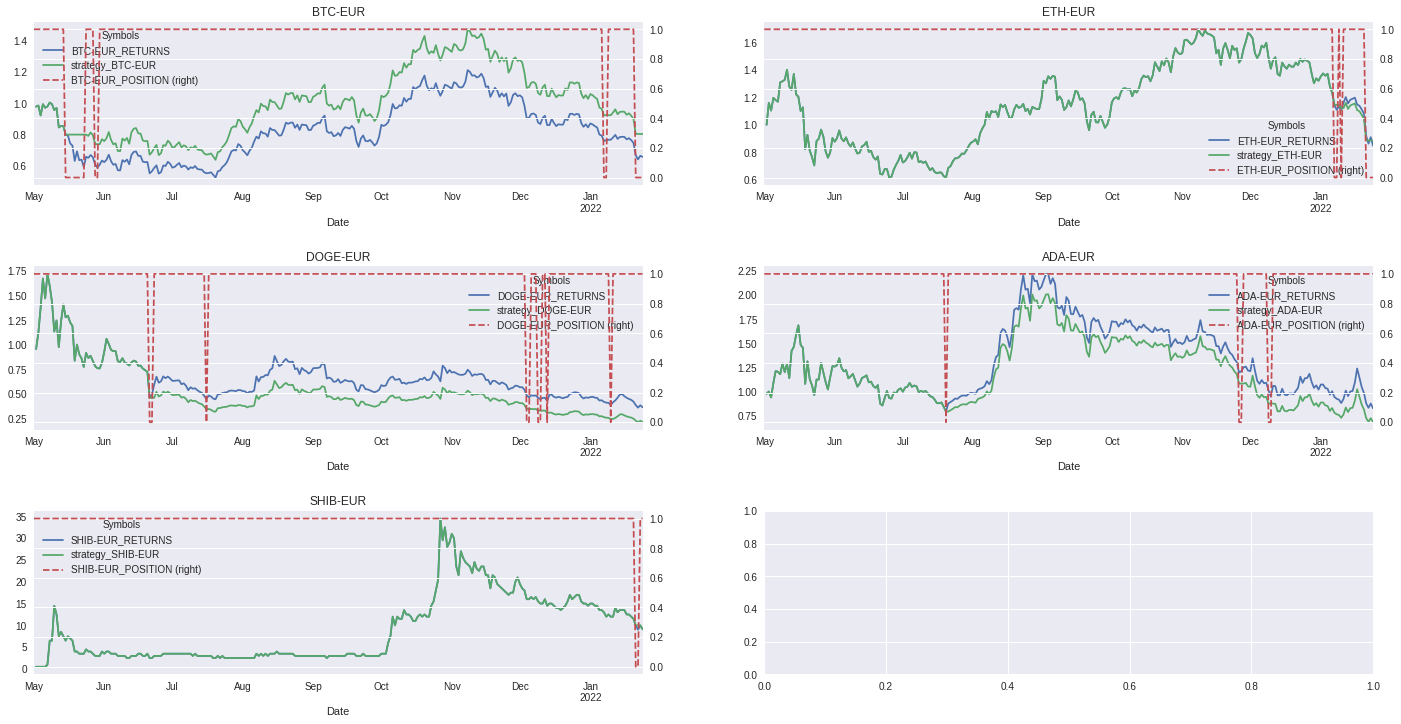

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f"{s}_RETURNS"] = np.log(df[s] / df[s].shift(1))
    df[f"strategy_{s}"] = df[f"{s}_POSITION"].shift(1) * df[f"{s}_RETURNS"]

    ax = (
        df[[f"{s}_RETURNS", f"strategy_{s}"]]
        .cumsum()
        .apply(np.exp)
        .plot(figsize=(24, 12), ax=axes[i // 2, i % 2])
    )
    df[[f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=ax, secondary_y=f"{s}_POSITION", style="--"
    )
    plt.title(s)


In [6]:
symbols = stocks[:]
results = pd.DataFrame()

data = pd.DataFrame(df[symbols])
data.dropna(inplace=True)

for rsi_periods in range(2, 16):
    t = 30
    current_df = pd.concat([data, rsi(data, symbols, rsi_periods, t)], axis=1)

    return_simulation = get_return_simulation(current_df, symbols)
    market = sum(
        [w * return_simulation[s]["base returns"] for s, w in zip(symbols, weights)]
    )
    strategy = sum(
        [w * return_simulation[s]["strategy returns"] for s, w in zip(symbols, weights)]
    )

    results = results.append(
        pd.DataFrame(
            {
                "periods": rsi_periods,
                "threshold": t,
                "market": market,
                "strategy": strategy,
                "out": strategy - market,
            },
            index=[0],
        ),
        ignore_index=True,
    )

results.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   periods    14 non-null     int64  
 1   threshold  14 non-null     int64  
 2   market     14 non-null     float64
 3   strategy   14 non-null     float64
 4   out        14 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 688.0 bytes


In [7]:
results.sort_values("out", ascending=False).head(10)


,periods,threshold,market,strategy,out
7,9,30,1.115311,0.879836,-0.235475
8,10,30,1.115311,0.875125,-0.240186
6,8,30,1.115311,0.850557,-0.264754
12,14,30,1.115311,0.845901,-0.269410
13,15,30,1.115311,0.844662,-0.270648
9,11,30,1.115311,0.843646,-0.271665
10,12,30,1.115311,0.841891,-0.273419
11,13,30,1.115311,0.825881,-0.289430
4,6,30,1.115311,0.815282,-0.300029
5,7,30,1.115311,0.809509,-0.305802
